# Лабораторная работа №3
Группа 3530903/70301  
Ижко Георгий, Шергалис Донат, Сидорова Елена

### 100,000 UK Used Car Data set
https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes


1. Выбрать набор данных для своей группы: <br>
    3530203_70101: Audi <br>
    3530203_70102: BMW <br>
    **3530903_70301: Ford** <br>
    3530903_70302: Mercedes<br>
    
2. Разбить данные на тренировочные и тестовые (70% на 30%, random_state=10).
3. Попытаться обучить регрессии c лучшим качеством. 


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
np.set_printoptions(precision=3)
pd.set_option('precision', 3)

import datetime

In [2]:
auto_data = pd.read_csv("data/ford.csv", delimiter=',\s*', engine='python')
auto_data

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,Fiesta,2016,7999,Manual,31348,Petrol,125,54.3,1.2
17961,B-MAX,2017,8999,Manual,16700,Petrol,150,47.1,1.4
17962,B-MAX,2014,7499,Manual,40700,Petrol,30,57.7,1.0
17963,Focus,2015,9999,Manual,7010,Diesel,20,67.3,1.6


# Анализ выбросов

## Анализ значений текстовых полей

In [3]:
# признак  | значения
for col in auto_data[['model', 'transmission', 'fuelType']]:
    values = auto_data[col].unique()
    str_values = str(values)
    if len(str_values) > 300:
        str_values = str_values[:300] + '...'
    print(col, ':', len(values), '\n', str_values, '\n')

model : 23 
 ['Fiesta' 'Focus' 'Puma' 'Kuga' 'EcoSport' 'C-MAX' 'Mondeo' 'Ka+'
 'Tourneo Custom' 'S-MAX' 'B-MAX' 'Edge' 'Tourneo Connect' 'Grand C-MAX'
 'KA' 'Galaxy' 'Mustang' 'Grand Tourneo Connect' 'Fusion' 'Ranger'
 'Streetka' 'Escort' 'Transit Tourneo'] 

transmission : 3 
 ['Automatic' 'Manual' 'Semi-Auto'] 

fuelType : 5 
 ['Petrol' 'Diesel' 'Hybrid' 'Electric' 'Other'] 



### Анализ списка типов топлива

In [4]:
fueltype_counts = auto_data.fuelType.value_counts()
fueltype_counts

Petrol      12178
Diesel       5762
Hybrid         22
Electric        2
Other           1
Name: fuelType, dtype: int64

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='fuelType', ylabel='count'>

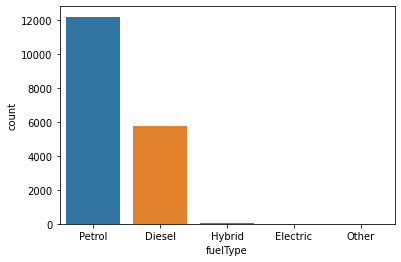

In [5]:
sns.countplot(auto_data.fuelType)

In [6]:
hybrids = auto_data[auto_data.fuelType == 'Hybrid']
set(hybrids.model)

{'Kuga', 'Mondeo', 'Puma'}

Эти машины действительно бывают гибридными.

In [7]:
rare_fueltype = auto_data[auto_data.fuelType.isin({'Other', 'Electric'})]
rare_fueltype

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6385,Mondeo,2016,15975,Automatic,9396,Electric,0,67.3,2.0
11959,Mondeo,2016,15500,Automatic,24531,Electric,0,67.3,2.0
17492,Mondeo,2015,13800,Automatic,19470,Other,0,67.3,2.0


Я не эксперт, но я бы не стал заливать Electric или Other в топливный бак Ford Mondeo.  
Зная, что существуют гибридные Mondeo, можем с должной уверенностью заменить эти значения на Hybrid.

In [8]:
rare_fueltype['fuelType'] = 'Hybrid'
rare_fueltype

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6385,Mondeo,2016,15975,Automatic,9396,Hybrid,0,67.3,2.0
11959,Mondeo,2016,15500,Automatic,24531,Hybrid,0,67.3,2.0
17492,Mondeo,2015,13800,Automatic,19470,Hybrid,0,67.3,2.0


### Анализ списка моделей

In [9]:
model_counts = auto_data.model.value_counts()
model_counts

Fiesta                   6557
Focus                    4588
Kuga                     2225
EcoSport                 1143
C-MAX                     543
Ka+                       531
Mondeo                    526
B-MAX                     355
S-MAX                     296
Grand C-MAX               247
Galaxy                    228
Edge                      208
KA                        199
Puma                       80
Tourneo Custom             69
Grand Tourneo Connect      59
Mustang                    57
Tourneo Connect            33
Fusion                     16
Streetka                    2
Ranger                      1
Transit Tourneo             1
Escort                      1
Name: model, dtype: int64

In [10]:
rare_models = model_counts[model_counts < 10]
rare_models_df = auto_data[auto_data.model.isin(rare_models.index)]
rare_models_df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
13607,Ranger,2013,14495,Manual,88000,Diesel,240,28.3,3.2
14691,Streetka,2005,1999,Manual,63000,Petrol,270,35.3,1.6
16878,Escort,1996,3000,Manual,50000,Petrol,265,34.4,1.8
17080,Streetka,2006,1850,Manual,74055,Petrol,290,35.8,1.6
17741,Transit Tourneo,2014,12450,Manual,19496,Diesel,235,42.2,2.2


Редкие машины можно считать выбросом и исключить из выборки.  

In [11]:
auto_data.drop(rare_models_df.index, inplace=True)

/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='model', ylabel='count'>

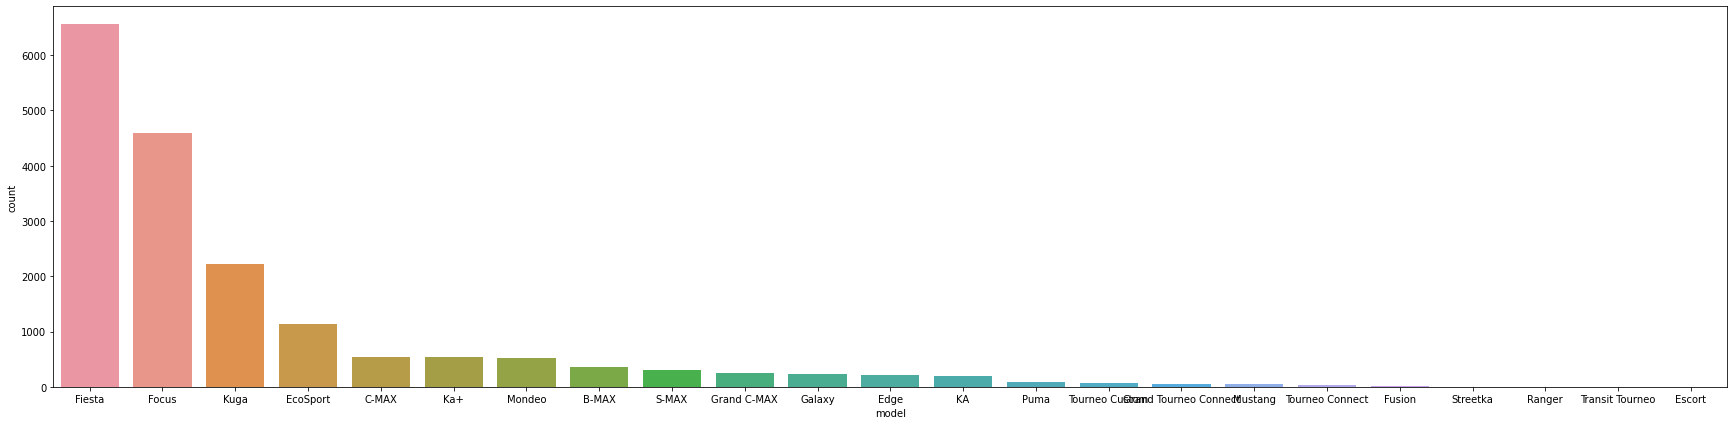

In [12]:
fig, ax = plt.subplots(figsize=(30,7))

sns.countplot(auto_data.model, ax=ax, order=model_counts.index)

In [13]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17960 entries, 0 to 17964
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         17960 non-null  object 
 1   year          17960 non-null  int64  
 2   price         17960 non-null  int64  
 3   transmission  17960 non-null  object 
 4   mileage       17960 non-null  int64  
 5   fuelType      17960 non-null  object 
 6   tax           17960 non-null  int64  
 7   mpg           17960 non-null  float64
 8   engineSize    17960 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 2.0+ MB


Нет null значений

In [14]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,17960.000,17960.000,17960.000,17960.000,17960.000,17960.000
mean,2016.869,12281.293,23353.734,113.294,57.913,1.351
std,2.041,4740.248,19461.891,61.970,10.120,0.432
min,1998.000,495.000,1.000,0.000,20.800,0.000
25%,2016.000,8999.000,9987.000,30.000,52.300,1.000
50%,2017.000,11291.000,18237.000,145.000,58.900,1.200
75%,2018.000,15299.000,31036.000,145.000,65.700,1.500
max,2060.000,54995.000,177644.000,580.000,201.800,5.000


* `year=2060` -- явная ошибка
* `price=495` -- реалистична
* `price=54995` --  стоит проверить
* `mpg=201.8` -- вероятно выброс (кол-во миль на галон)
* `mileage=177644` -- реалистичный пробег
* `tax=0` -- наверное, корректное значение
* `engineSize=0` -- пустое значение
* `engineSize=5` -- стоит проверить

### Выбросы engineSize

In [15]:
def get_engine_by_size(size, df = auto_data):
    return df[df.engineSize == size]

zero_engine = get_engine_by_size(0)
print(len(zero_engine), ":", set(zero_engine.fuelType))

51 : {'Hybrid', 'Petrol', 'Diesel'}


Попахивает неправдой.

In [16]:
auto_data.drop(zero_engine.index, inplace=True)

In [17]:
big_engine = get_engine_by_size(5)
set(big_engine.model)

{'Mondeo', 'Mustang'}

Что здесь забыл Mondeo? Выпихиваем.

In [18]:
mondeo_liar = big_engine[big_engine.model == 'Mondeo']
auto_data.drop(mondeo_liar.index, inplace=True)

### Выбросы year

In [19]:
def get_year_over(year = datetime.datetime.now().year, df = auto_data):
    return df[df.year > year]

from_future = get_year_over()
from_future

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
17726,Fiesta,2060,6495,Automatic,54807,Petrol,205,42.8,1.4


Я не обнаружил в интернете информации о моделях Ford, выпускавшихся в 2060 году.  
Можно предположить, что на самом деле там должно быть значение 2006.  
А можно просто хладнокровно вырвать эту строчку из датасета.

In [20]:
auto_data.drop(from_future.index, inplace=True)

Получим данные по выпуску всех моделей Ford:

In [21]:
# Использованы следующие ресурсы:
# ???
# https://www.auto-data.net/en/ford-all-72
# https://www.autoevolution.com/ford/?sort=name

ford_years = pd.read_csv("data/ford_models.csv", delimiter=';')
ford_years.replace(-1, datetime.datetime.now().year, inplace=True)
ford_years.head()

,model,model_detailed,begin,end,gasoline,diesel,hybrid
0,BRONCO,FORD Bronco,2020,2021.0,1.0,0.0,0.0
1,ECOSPORT,FORD EcoSport,2017,2021.0,1.0,1.0,0.0
2,EDGE,FORD Edge,2018,2021.0,1.0,1.0,0.0
3,EDGE ST,FORD Edge ST,2018,2021.0,1.0,0.0,0.0
4,ESCAPE,FORD Escape,2019,2021.0,1.0,1.0,1.0


In [22]:
# 
"""
wrong_data_indices = []
for i, row in auto_data.iterrows():
    model = row.model.strip().upper()
    actual_years = ford_years[ford_years.model == model]
    if not any((actual_years.begin <= row.year) & (row.year <= actual_years.end)):
        wrong_data_indices.append(i)
auto_data[auto_data.index.isin(wrong_data_indices)]
# """

'\nwrong_data_indices = []\nfor i, row in auto_data.iterrows():\n    model = row.model.strip().upper()\n    actual_years = ford_years[ford_years.model == model]\n    if not any((actual_years.begin <= row.year) & (row.year <= actual_years.end)):\n        wrong_data_indices.append(i)\nauto_data[auto_data.index.isin(wrong_data_indices)]\n# '

### Выбросы price

<AxesSubplot:title={'center':'price'}, xlabel='model'>

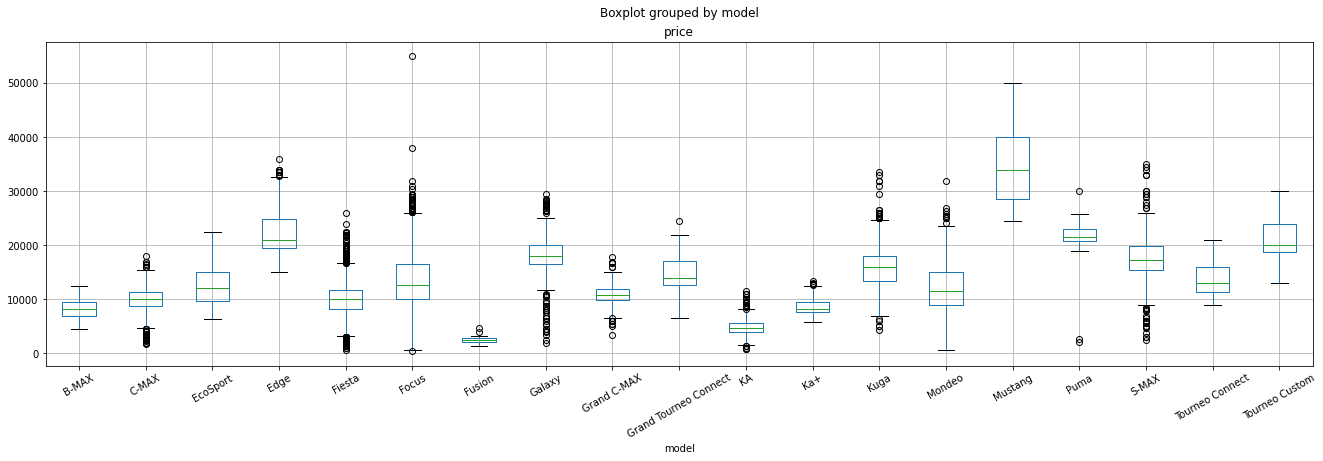

In [23]:
fig, ax = plt.subplots(figsize=(22,6))
auto_data.boxplot(column=['price'], by='model', ax=ax, rot=30)

In [24]:
overprice = auto_data[auto_data.price > 50000]

Для Фокуса 55к бачинских многовато будет. [Разве что...](https://i.pinimg.com/originals/8a/32/12/8a32122ffae41e0c2d10ebb7ecc8e595.jpg) Но это всё равно выброс. Выбрасываем выброс.

**Как видно, некоторые Прайсы объединяются в отдельные кластеры, например у Ford Puma большинство значений находятся около 20000, но есть група значений менее 10000. Это может быть связано с тем, что модель выпускалась в течение долгого периода, имеет несколько поколений, некоторые из которых старые и никому не нужные.**

In [25]:
auto_data.drop(overprice.index, inplace=True)

<AxesSubplot:title={'center':'price'}, xlabel='year'>

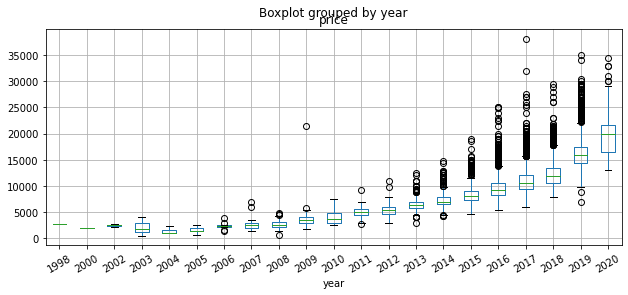

In [26]:
cheap_cars = auto_data[(auto_data.model.isin(['Puma', 'Focus', 'Fiesta', 'S-MAX']))]
fig, ax = plt.subplots(figsize=(10,4))
cheap_cars.boxplot(column=['price'], by='year', ax=ax, rot=30)

Как видно, сильный разброс в ценах перечисленных моделей вызвана разбросом в возрасте этих автомобилей из-за длительного промежутка их выпуска. 
Единственным выбросом является автомобиль 2009 года стоимостью более 20000:

In [27]:
overprice = auto_data[(auto_data.year == 2009) & (auto_data.price > 20000)]
overprice

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
17100,Focus,2009,21500,Manual,44482,Petrol,330,30.1,2.5


In [28]:
auto_data[(auto_data.year == 2009) & (auto_data.model == 'Focus')].head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
13545,Focus,2009,1950,Manual,50000,Petrol,205,42.2,1.6
13819,Focus,2009,2499,Manual,85000,Petrol,200,42.2,1.6
15678,Focus,2009,1999,Manual,113492,Petrol,200,42.2,1.6
15682,Focus,2009,2495,Manual,107000,Petrol,205,42.2,1.6
15683,Focus,2009,2995,Manual,98000,Diesel,145,54.3,1.8


Как видно, остальные Ford Focus этого года выпуска при схожих параметрах имеют значительно меньшую цену. 

## Model / year

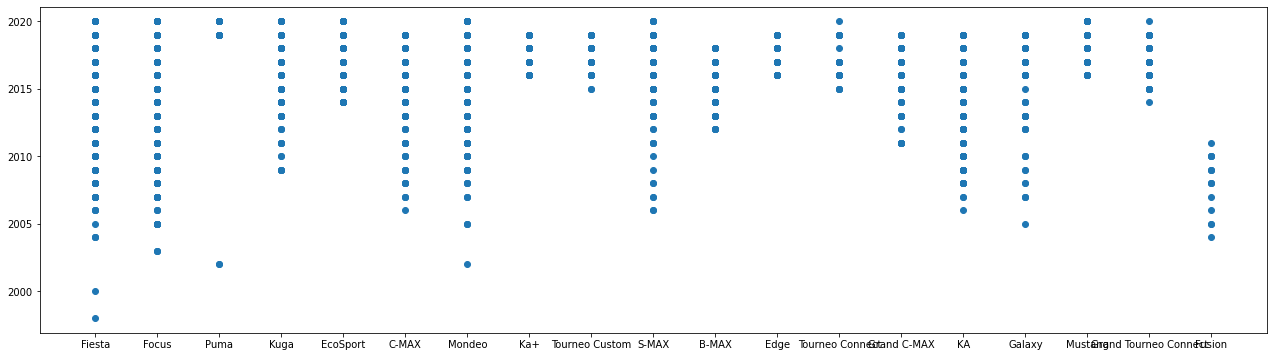

In [29]:
fig, ax = plt.subplots(figsize=(22,6))
plt.scatter( auto_data['model'], auto_data['year'])

In [30]:
pumas = auto_data[auto_data.model == 'Puma']
pumas_old = pumas[pumas.year == 2002]
pumas_new = pumas[pumas.year > 2002]

**Как видно, некоторые модели выпускались в течение многих лет и имели множество поколений. Отделение этих поколений друг от друга позволит повысить точность оценки стоимости.**

Ford Puma: 1997-2002 -- купе, около 2500 фунтов; 2019 -- кроссовер, около 20000 фунтов. 


### Выбросы mpg

In [31]:
def get_mpg_over(threshold, df = auto_data):
    return df[df.mpg > threshold]

high_mpg = get_mpg_over(100)
high_mpg
# print(len(high_mpg), ":", set(high_mpg.model))

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
6153,Kuga,2020,31000,Semi-Auto,10,Hybrid,135,201.8,2.5
6536,Kuga,2020,31991,Semi-Auto,2357,Hybrid,135,201.8,2.5
9220,Kuga,2020,32000,Automatic,10,Hybrid,140,201.8,2.5
12862,Kuga,2020,33500,Automatic,5534,Hybrid,140,201.8,2.5
13730,Kuga,2020,32995,Automatic,11,Hybrid,135,201.8,2.5


<AxesSubplot:>

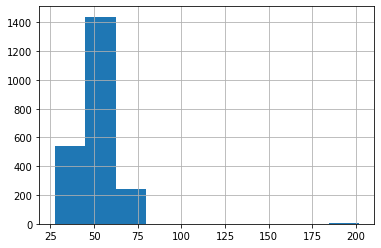

In [32]:
auto_data[auto_data.model == 'Kuga'].mpg.hist()

**Хитрюги использовали значения mpg, полученные по хитрой методике: https://www.parkers.co.uk/ford/kuga/review/mpg-running-costs/  
Заменяем значения на реалистичные хитрые:**

In [33]:
auto_data.mpg.replace(201.8, 52.3, inplace=True)

<AxesSubplot:>

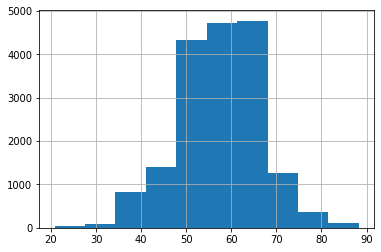

In [34]:
auto_data.mpg.hist()

<AxesSubplot:title={'center':'mpg'}, xlabel='model'>

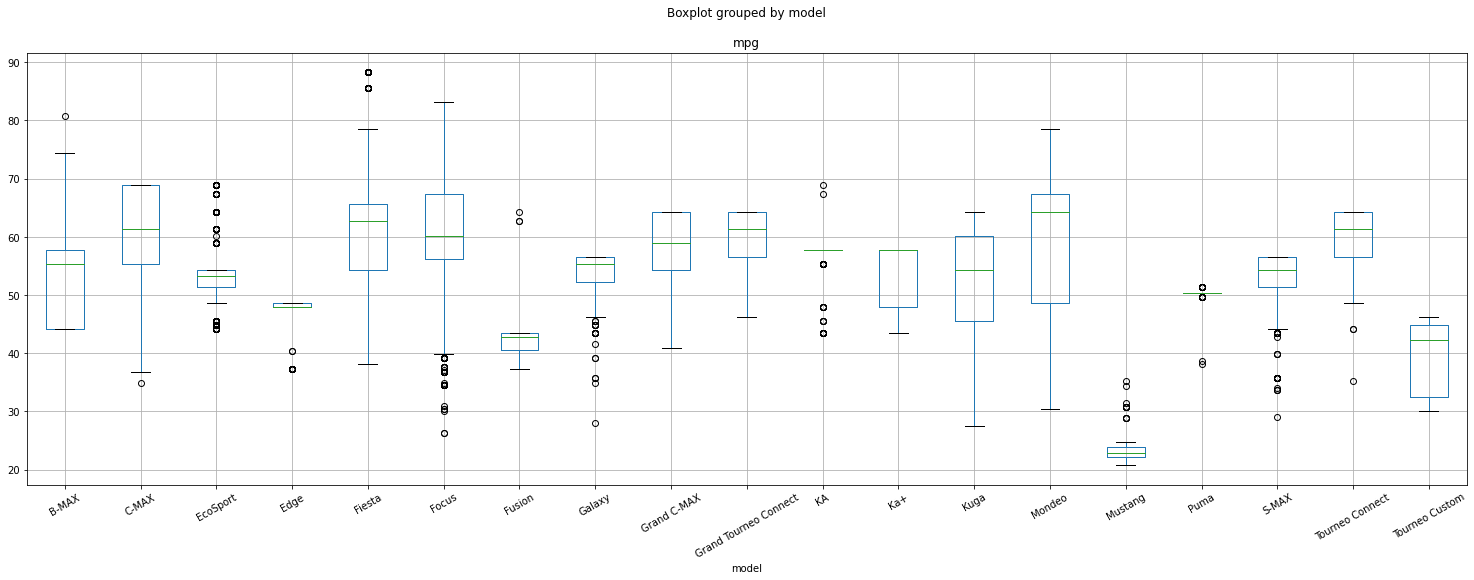

In [35]:
fig, ax = plt.subplots(figsize=(25,8))
auto_data.boxplot(column=['mpg'], by='model', ax=ax, rot=30)

**Вероятно, некоторые продавцы публикуют собственные данные, а другие используют маркетинговые. 
У нескольких моделей есть пара значений, сильно выделяющися на фоне остальных.**

In [36]:
fusion = auto_data[auto_data.model == 'Fusion']
print("высокий mpg", set(fusion[fusion.mpg > 50].fuelType))
print("низкий mpg", set(fusion[fusion.mpg < 50].fuelType))

высокий mpg {'Diesel'}
низкий mpg {'Petrol'}


**Как видно, разброс в mpg у одной модели (одного поколения) объясняется с видом используемого топлива.**  
**Для улучшения предсказаний можно попробовать объединить колонки model и fuelType**

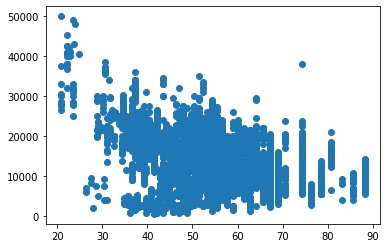

In [37]:
plt.scatter(auto_data.mpg, auto_data.price)

**Хорошо видна общая тенденция, при которой более дорогие автомобили, такие как Mustang, являются менее экономными. Выделяется лишь одно значение.**

In [38]:
overprice = auto_data[(auto_data.price > 30000) & (auto_data.mpg > 70)]
overprice

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
1039,Focus,2017,38015,Manual,197,Diesel,145,74.3,1.5


**Уже не первый раз Фокус показывает трюки. Пропустили его, когда анализировали зависимость цены от модели, но вот он выполз. Теперь, придерживаясь выбранной стратегии, избавимся от шутника:**

In [39]:
auto_data.drop(overprice.index, inplace=True)

### Выбросы mileage

<AxesSubplot:>

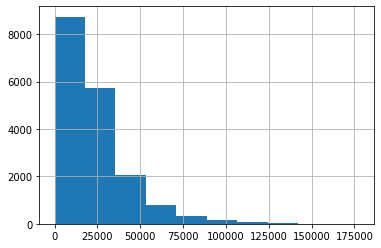

In [40]:
auto_data.mileage.hist()

Распределение выглядит реалистично.

### Проверка результата выброса выбросов:

In [41]:
auto_data.describe()

,year,price,mileage,tax,mpg,engineSize
count,17905.000,17905.000,17905.000,17905.000,17905.000,17905.000
mean,2016.866,12279.051,23365.416,113.291,57.877,1.354
std,2.017,4728.216,19465.782,61.969,9.830,0.426
min,1998.000,495.000,1.000,0.000,20.800,1.000
25%,2016.000,8999.000,9987.000,30.000,52.300,1.000
50%,2017.000,11291.000,18248.000,145.000,58.900,1.200
75%,2018.000,15299.000,31073.000,145.000,65.700,1.500
max,2020.000,49999.000,177644.000,580.000,88.300,5.000


## Линейная регрессия

In [42]:
# закодируем строковые поля числовыми метками:
from sklearn.preprocessing import LabelEncoder

string_cols = ("model", "transmission", "fuelType")
auto_data_with_labels = auto_data.copy()

for col in string_cols:
    lbl = LabelEncoder()
    lbl.fit(list(auto_data_with_labels[col].values))
    auto_data_with_labels[col] = lbl.transform(list(auto_data_with_labels[col].values))

auto_data_with_labels

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,4,2017,12000,0,15944,4,150,57.7,1.0
1,5,2018,14000,1,9083,4,150,57.7,1.0
2,5,2017,13000,1,12456,4,150,57.7,1.0
3,4,2019,17500,1,10460,4,145,40.3,1.5
4,4,2019,16500,0,1482,4,145,48.7,1.0
...,...,...,...,...,...,...,...,...,...
17960,4,2016,7999,1,31348,4,125,54.3,1.2
17961,0,2017,8999,1,16700,4,150,47.1,1.4
17962,0,2014,7499,1,40700,4,30,57.7,1.0
17963,5,2015,9999,1,7010,0,20,67.3,1.6


In [43]:
new_column = auto_data.model + " " + auto_data.fuelType + " "

In [44]:
# Нет, давайте лучше будет dummy encoding

auto_data_dummy = pd.concat([auto_data.drop(['model', 'fuelType', 'transmission'], axis=1), 
                             pd.get_dummies(new_column),
                             pd.get_dummies(auto_data['fuelType']), 
                             pd.get_dummies(auto_data['transmission'])], axis = 1)
auto_data_with_labels = auto_data_dummy
auto_data_with_labels.head()

,year,price,mileage,tax,mpg,engineSize,B-MAX Diesel,B-MAX Petrol,C-MAX Diesel,C-MAX Petrol,...,Tourneo Connect Petrol,Tourneo Custom Diesel,Diesel,Electric,Hybrid,Other,Petrol,Automatic,Manual,Semi-Auto
0,2017,12000,15944,150,57.7,1.0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,2018,14000,9083,150,57.7,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,2017,13000,12456,150,57.7,1.0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,2019,17500,10460,145,40.3,1.5,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,2019,16500,1482,145,48.7,1.0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [45]:
auto_data_with_labels_without_price = auto_data_with_labels.drop(['price'], axis=1)
auto_data_with_labels_without_price

,year,mileage,tax,mpg,engineSize,B-MAX Diesel,B-MAX Petrol,C-MAX Diesel,C-MAX Petrol,EcoSport Diesel,...,Tourneo Connect Petrol,Tourneo Custom Diesel,Diesel,Electric,Hybrid,Other,Petrol,Automatic,Manual,Semi-Auto
0,2017,15944,150,57.7,1.0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,2018,9083,150,57.7,1.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,2017,12456,150,57.7,1.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,2019,10460,145,40.3,1.5,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,2019,1482,145,48.7,1.0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17960,2016,31348,125,54.3,1.2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
17961,2017,16700,150,47.1,1.4,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
17962,2014,40700,30,57.7,1.0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
17963,2015,7010,20,67.3,1.6,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [46]:
X, Y = auto_data_with_labels_without_price, auto_data_with_labels['price']

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [48]:
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

X_train_scaled

array([[ 0.566, -0.546,  0.51 , ..., -0.285,  0.394, -0.251],
       [ 0.071,  0.113,  0.187, ..., -0.285,  0.394, -0.251],
       [-0.424, -0.363,  0.51 , ..., -0.285,  0.394, -0.251],
       ...,
       [ 0.071,  0.062,  0.59 , ..., -0.285,  0.394, -0.251],
       [ 0.071, -0.674, -1.827, ..., -0.285,  0.394, -0.251],
       [-3.396,  1.598,  1.315, ...,  3.508, -2.536, -0.251]])

### LinearRegression()

In [49]:
simple_LR = LinearRegression()

simple_LR.fit(X_train_scaled, Y_train)
simple_LR_predictions = simple_LR.predict(X_test_scaled)

simple_LR_MSE = metrics.mean_squared_error(Y_test, simple_LR_predictions)

print (f'MSE = {round(simple_LR_MSE,3)}')

MSE = 2.4328114303907508e+26


In [50]:
simple_LR_RMSE = metrics.mean_squared_error(Y_test, simple_LR_predictions, squared = False)

print (f'RMSE = {round(simple_LR_RMSE,3)}')

RMSE = 15597472328524.102


In [51]:
print (f'Test std: {round(Y_test.std(),3)}')

Test std: 4724.902


Text(0, 0.5, 'Target')

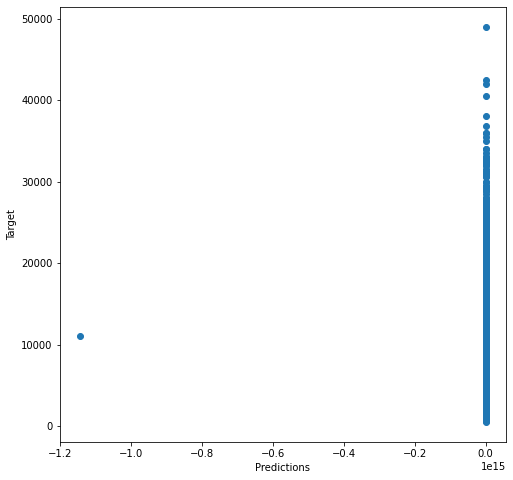

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(simple_LR_predictions, Y_test)
plt.xlabel('Predictions')
plt.ylabel('Target')

In [53]:
simple_LR.intercept_, simple_LR.coef_

(12268.975332112921,
 array([ 2.334e+03, -1.208e+03, -1.588e+02, -1.024e+03,  1.145e+03,
         9.954e+13,  1.663e+14,  2.083e+14,  1.484e+14,  1.350e+14,
         3.030e+14,  1.690e+14,  2.301e+14,  6.245e+14,  4.389e+14,
         4.869e+14,  1.956e+13,  3.105e+13,  1.722e+14,  3.105e+13,
         1.489e+14,  9.220e+13,  9.365e+13,  1.383e+13,  1.290e+14,
         4.054e+14,  2.210e+14,  4.565e+14,  4.689e+13,  2.117e+14,
         2.367e+14,  1.749e+14,  9.757e+13,  1.458e+16,  8.447e+13,
         7.319e+13,  8.528e+13,  1.873e+14,  4.977e+13,  6.334e+13,
         1.660e+13,  9.859e+13,  8.590e+14, -1.320e+14,  1.285e+13,
        -1.455e+16,  9.695e+14, -1.668e+15, -2.159e+15, -1.496e+15]))

In [54]:
pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

,Coefficients
year,2.334e+03
mileage,-1.208e+03
tax,-1.588e+02
mpg,-1.024e+03
engineSize,1.145e+03
B-MAX Diesel,9.954e+13
B-MAX Petrol,1.663e+14
C-MAX Diesel,2.083e+14
C-MAX Petrol,1.484e+14
EcoSport Diesel,1.350e+14


### Lasso()

In [55]:
model = Lasso()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 1809.249


,Coefficients
year,2.334e+03
mileage,-1.208e+03
tax,-1.588e+02
mpg,-1.024e+03
engineSize,1.145e+03
B-MAX Diesel,9.954e+13
B-MAX Petrol,1.663e+14
C-MAX Diesel,2.083e+14
C-MAX Petrol,1.484e+14
EcoSport Diesel,1.350e+14


### LassoCV()

In [56]:
model = LassoCV()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 1809.301


,Coefficients
year,2.334e+03
mileage,-1.208e+03
tax,-1.588e+02
mpg,-1.024e+03
engineSize,1.145e+03
B-MAX Diesel,9.954e+13
B-MAX Petrol,1.663e+14
C-MAX Diesel,2.083e+14
C-MAX Petrol,1.484e+14
EcoSport Diesel,1.350e+14


### LassoCV() with alphas

In [57]:
alphas = np.linspace(1, 10, 20)
alphas

array([ 1.   ,  1.474,  1.947,  2.421,  2.895,  3.368,  3.842,  4.316,
        4.789,  5.263,  5.737,  6.211,  6.684,  7.158,  7.632,  8.105,
        8.579,  9.053,  9.526, 10.   ])

In [58]:
model = LassoCV(random_state = 10, alphas=alphas)

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 1809.249


,Coefficients
year,2.334e+03
mileage,-1.208e+03
tax,-1.588e+02
mpg,-1.024e+03
engineSize,1.145e+03
B-MAX Diesel,9.954e+13
B-MAX Petrol,1.663e+14
C-MAX Diesel,2.083e+14
C-MAX Petrol,1.484e+14
EcoSport Diesel,1.350e+14


### Ridge()

In [59]:
model = Ridge()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 1809.259


,Coefficients
year,2.334e+03
mileage,-1.208e+03
tax,-1.588e+02
mpg,-1.024e+03
engineSize,1.145e+03
B-MAX Diesel,9.954e+13
B-MAX Petrol,1.663e+14
C-MAX Diesel,2.083e+14
C-MAX Petrol,1.484e+14
EcoSport Diesel,1.350e+14


### RidgeCV()

In [60]:
model = RidgeCV()

model.fit(X_train_scaled, Y_train)
predictions = model.predict(X_test_scaled)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(simple_LR.coef_,  auto_data_with_labels_without_price.columns, columns=['Coefficients'])

RMSE = 1809.127


,Coefficients
year,2.334e+03
mileage,-1.208e+03
tax,-1.588e+02
mpg,-1.024e+03
engineSize,1.145e+03
B-MAX Diesel,9.954e+13
B-MAX Petrol,1.663e+14
C-MAX Diesel,2.083e+14
C-MAX Petrol,1.484e+14
EcoSport Diesel,1.350e+14


### RandomForestRegressor

In [61]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state = 10, n_estimators = 100)

model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print (f'RMSE = {round(metrics.mean_squared_error(Y_test, predictions, squared=False), 3)}')

pd.DataFrame(model.feature_importances_, auto_data_with_labels_without_price.columns, 
             columns=['Importance']).sort_values('Importance')

RMSE = 1236.046


,Importance
Ka+ Diesel,0.000e+00
Mondeo Other,5.208e-07
Other,1.021e-06
Mondeo Electric,1.228e-06
KA Diesel,2.218e-06
Fusion Diesel,3.072e-06
Electric,3.232e-06
Tourneo Connect Petrol,4.724e-06
Fusion Petrol,7.511e-06
Mondeo Hybrid,3.908e-05


Text(0, 0.5, 'Target')

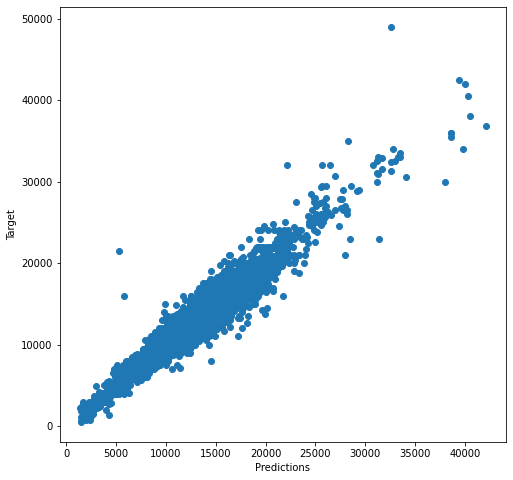

In [62]:
plt.figure(figsize=(8, 8))
plt.scatter(predictions, Y_test)
plt.xlabel('Predictions')
plt.ylabel('Target')